In [29]:
pip install ucimlrepo

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score  # Import accuracy metric

In [31]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
rt_iot2022 = fetch_ucirepo(id=942) 
  
# data (as pandas dataframes) 
X = rt_iot2022.data.features 
y = rt_iot2022.data.targets 
  
# metadata 
print(rt_iot2022.metadata) 
  
# variable information 
print(rt_iot2022.variables) 


{'uci_id': 942, 'name': 'RT-IoT2022 ', 'repository_url': 'https://archive.ics.uci.edu/dataset/942/rt-iot2022', 'data_url': 'https://archive.ics.uci.edu/static/public/942/data.csv', 'abstract': 'The RT-IoT2022, a proprietary dataset derived from a real-time IoT infrastructure, is introduced as a comprehensive resource integrating a diverse range of IoT devices and sophisticated network attack methodologies. This dataset encompasses both normal and adversarial network behaviours, providing a general representation of real-world scenarios.\nIncorporating data from IoT devices such as ThingSpeak-LED, Wipro-Bulb, and MQTT-Temp, as well as simulated attack scenarios involving Brute-Force SSH attacks, DDoS attacks using Hping and Slowloris, and Nmap patterns, RT-IoT2022 offers a detailed perspective on the complex nature of network traffic. The bidirectional attributes of network traffic are meticulously captured using the Zeek network monitoring tool and the Flowmeter plugin. Researchers can

In [32]:
customers_data=pd.concat([X, y], axis=1)
customers_data.head()


,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,Attack_type
0,38667,1883,tcp,mqtt,32.011598,9,5,3,3,0.281148,...,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240,26847,502,MQTT_Publish
1,51143,1883,tcp,mqtt,31.883584,9,5,3,3,0.282277,...,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240,26847,502,MQTT_Publish
2,44761,1883,tcp,mqtt,32.124053,9,5,3,3,0.280164,...,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240,26847,502,MQTT_Publish
3,60893,1883,tcp,mqtt,31.961063,9,5,3,3,0.281593,...,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240,26847,502,MQTT_Publish
4,51087,1883,tcp,mqtt,31.902362,9,5,3,3,0.282111,...,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240,26847,502,MQTT_Publish


In [33]:
customers_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 84 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id.orig_p                 123117 non-null  int64  
 1   id.resp_p                 123117 non-null  int64  
 2   proto                     123117 non-null  object 
 3   service                   123117 non-null  object 
 4   flow_duration             123117 non-null  float64
 5   fwd_pkts_tot              123117 non-null  int64  
 6   bwd_pkts_tot              123117 non-null  int64  
 7   fwd_data_pkts_tot         123117 non-null  int64  
 8   bwd_data_pkts_tot         123117 non-null  int64  
 9   fwd_pkts_per_sec          123117 non-null  float64
 10  bwd_pkts_per_sec          123117 non-null  float64
 11  flow_pkts_per_sec         123117 non-null  float64
 12  down_up_ratio             123117 non-null  float64
 13  fwd_header_size_tot       123117 non-null  i

In [34]:
customers_data.isna().sum()

id.orig_p               0
id.resp_p               0
proto                   0
service                 0
flow_duration           0
                       ..
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Attack_type             0
Length: 84, dtype: int64

In [35]:
customers_data.isin(['?']).sum()
customers_data.replace('?',np.NaN,inplace =True)


In [36]:
customers_data.isin([np.NaN]).sum()
customers_data.isnull().sum()
customers_data.dropna(how='any',inplace=True)




In [37]:
print(customers_data.duplicated().value_counts()) ##checking for duplicated data
customers_data=customers_data.drop_duplicates() # dropping duplicated data
print(customers_data.duplicated().value_counts())

False    117922
True       5195
Name: count, dtype: int64
False    117922
Name: count, dtype: int64


In [38]:
random_seed=42
data_copy_sample=customers_data.copy() #Using all the dataa

In [39]:
def change_string_to_int(column):
    variables=pd.unique(customers_data[column])
    for item in range(variables.size):
        customers_data[column]=[item if each==variables[item] else each for each in customers_data[column]]
    return customers_data[column]

In [40]:
for column in data_copy_sample.columns:
    if data_copy_sample[column].dtype != 'int64' and data_copy_sample[column].dtype != 'float64':
        data_copy_sample[column] = change_string_to_int(column)

In [41]:

X=data_copy_sample.drop(columns=['Attack_type'],axis=1) #dropping class 
y=data_copy_sample['Attack_type']
X.head()

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,...,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
0,38667,1883,0,0,32.011598,9,5,3,3,0.281148,...,2282414.913,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240,26847,502
1,51143,1883,0,0,31.883584,9,5,3,3,0.282277,...,2028306.961,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240,26847,502
2,44761,1883,0,0,32.124053,9,5,3,3,0.280164,...,2281903.982,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240,26847,502
3,60893,1883,0,0,31.961063,9,5,3,3,0.281593,...,2047288.179,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240,26847,502
4,51087,1883,0,0,31.902362,9,5,3,3,0.282111,...,2087656.975,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240,26847,502


In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [43]:
#splitting the data into 70-30 ratio
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)


In [44]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "Decision Tree": DecisionTreeClassifier(random_state=42)  # Added DT
}


In [45]:
k_values = range(3, 21)
# Dictionary to store results
results = []

In [46]:
# Perform cross-validation for each K value
for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)  # Shuffle to reduce order bias

    for model_name, model in models.items():
        # Compute cross-validation scores
        model.fit(X_train, y_train)

        # Predict on test data
        y_pred = model.predict(X_test)

        # Compute test accuracy
        test_accuracy = accuracy_score(y_test, y_pred)

        # Compute variance using cross-validation on training data
        train_accuracies = cross_val_score(model, X_train, y_train, cv=kf)
        train_accuracy_mean = np.mean(train_accuracies)  # Training accuracy
        train_accuracy_variance = np.var(train_accuracies)  # Training accuracy variance


        # Compute bias using test set (1 - Accuracy)
        ##bias = 1 - accuracy

        bias = train_accuracy_mean - test_accuracy

        results.append({
            "Model": model_name,
            "K": k,
            "Training Accuracy": train_accuracy_mean,
            "Variance": train_accuracy_variance,
            "Test Accuracy": test_accuracy,
            "Bias": bias
        })

        


/Users/dr.farhana/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dr.farhana/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

In [47]:
# Convert results into a DataFrame
import pandas as pd
df_results = pd.DataFrame(results)

# Save results to a CSV file
df_results.to_csv("bias_variance_results.csv", index=False)

# Display results without ace_tools
print(df_results.head())  # Print first 5 rows for verification

                    Model  K  Training Accuracy      Variance  Test Accuracy  \
0     Logistic Regression  3           0.987801  2.380506e-07       0.988241   
1     K-Nearest Neighbors  3           0.995530  9.862516e-08       0.996043   
2  Support Vector Machine  3           0.993240  1.752358e-07       0.993923   
3           Decision Tree  3           0.996753  1.438284e-08       0.997117   
4     Logistic Regression  4           0.988031  6.317816e-07       0.988241   

       Bias  
0 -0.000440  
1 -0.000513  
2 -0.000683  
3 -0.000363  
4 -0.000210  


In [48]:
df_check = pd.read_csv("bias_variance_results.csv")
print(df_check.head())  # Print first few rows

                    Model  K  Training Accuracy      Variance  Test Accuracy  \
0     Logistic Regression  3           0.987801  2.380506e-07       0.988241   
1     K-Nearest Neighbors  3           0.995530  9.862516e-08       0.996043   
2  Support Vector Machine  3           0.993240  1.752358e-07       0.993923   
3           Decision Tree  3           0.996753  1.438284e-08       0.997117   
4     Logistic Regression  4           0.988031  6.317816e-07       0.988241   

       Bias  
0 -0.000440  
1 -0.000513  
2 -0.000683  
3 -0.000363  
4 -0.000210  


In [49]:
# Function to plot Bias vs K and Variance vs K for each model
def plot_results(df, metric, ylabel, title_suffix):
    for model_name in df["Model"].unique():
        plt.figure(figsize=(8, 5))

        # Filter data for a specific model
        model_data = df[df["Model"] == model_name]
        x = model_data["K"].values
        y = model_data[metric].values

        # Scatter plot (Black markers)
        plt.scatter(x, y, color="black", label=f"{model_name} {ylabel}")

        # Fit and plot a straight trend line (Linear regression of degree 1)
        z = np.polyfit(x, y, 1)  # Linear trend line
        p = np.poly1d(z)
        plt.plot(x, p(x), color="black")  # Solid black trend line
        
        # Labels and title
        plt.xlabel("K Value")
        plt.ylabel(ylabel)
        plt.title(f"{ylabel} vs K Value ({model_name})")
        plt.legend()
        plt.grid(color='gray', linestyle='solid', linewidth=0.5)
        plt.show()

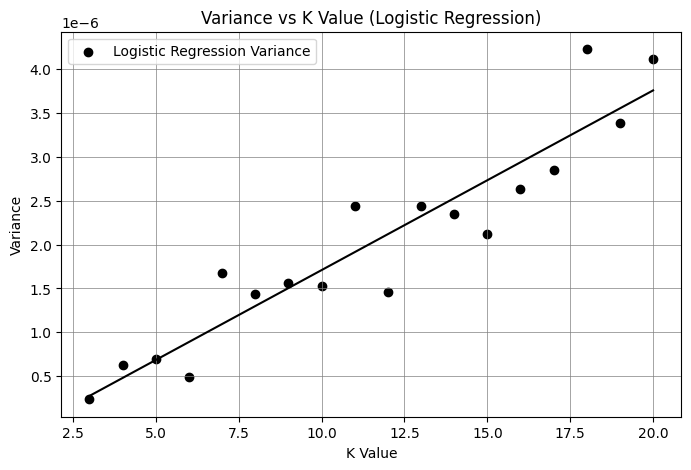

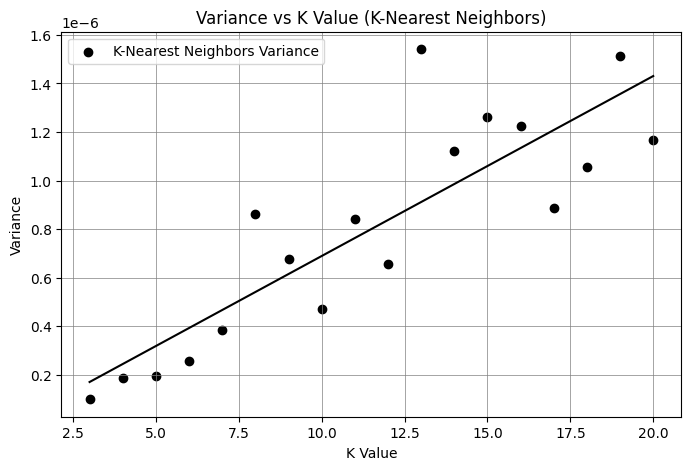

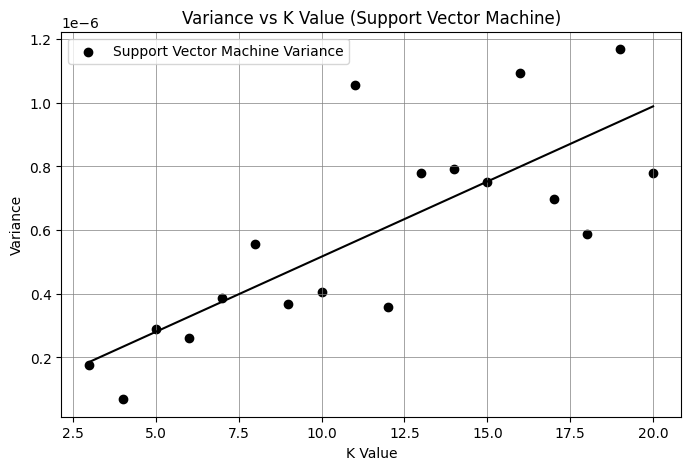

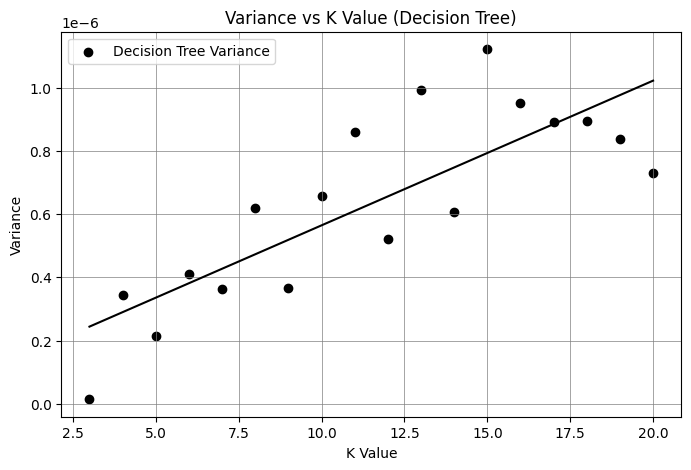

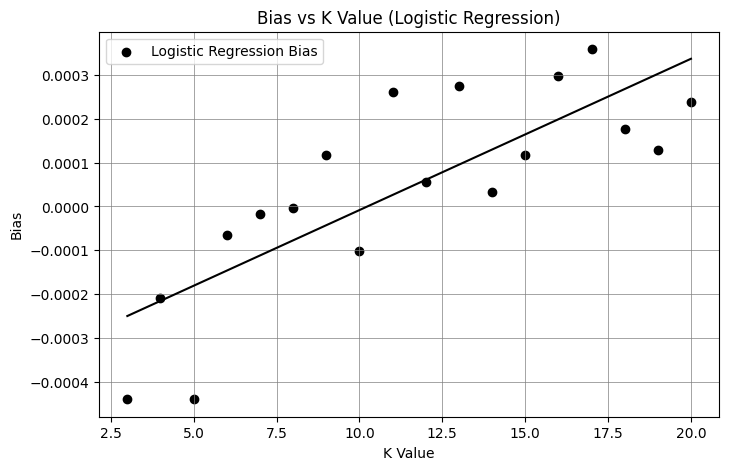

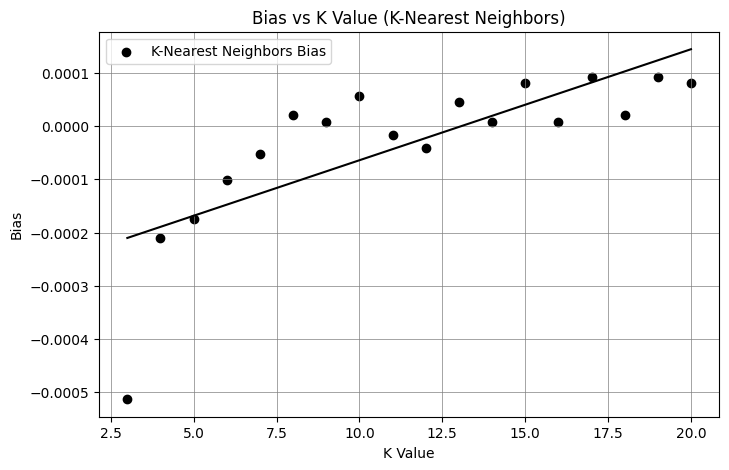

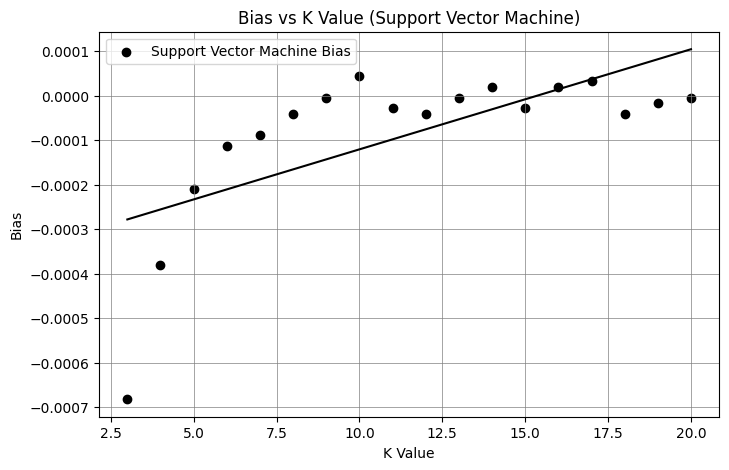

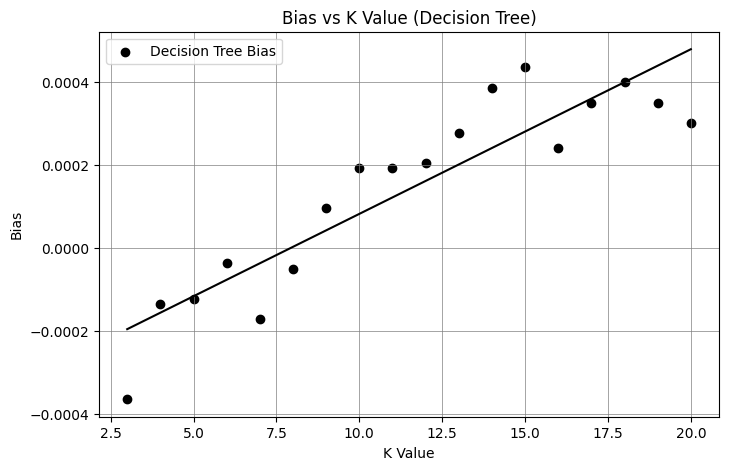

In [50]:
# Generate plots only for Bias and Variance
plot_results(df_results, "Variance", "Variance", "Effect of K on Variance")
plot_results(df_results, "Bias", "Bias", "Effect of K on Bias (Train Accuracy - Test Accuracy)")

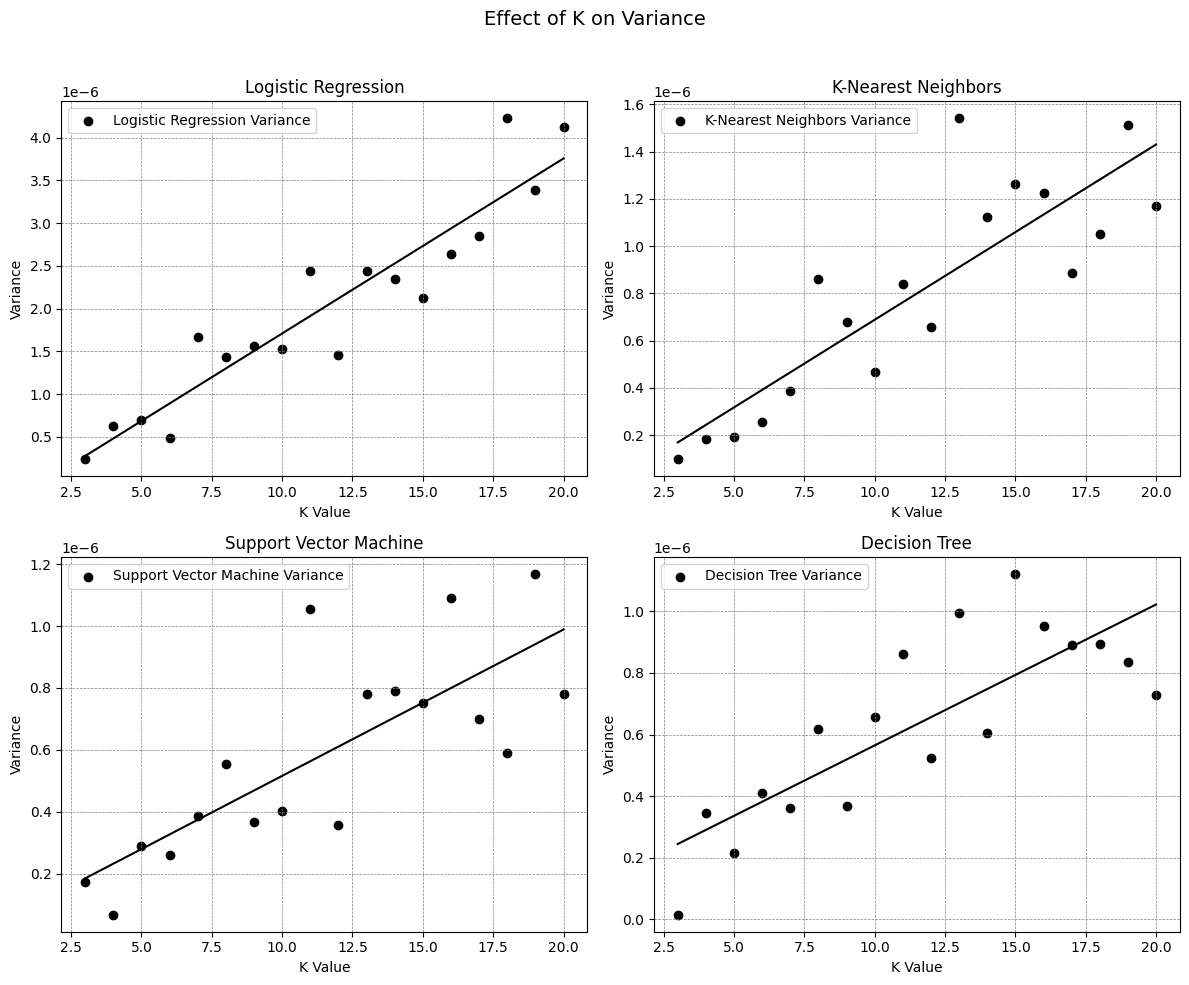

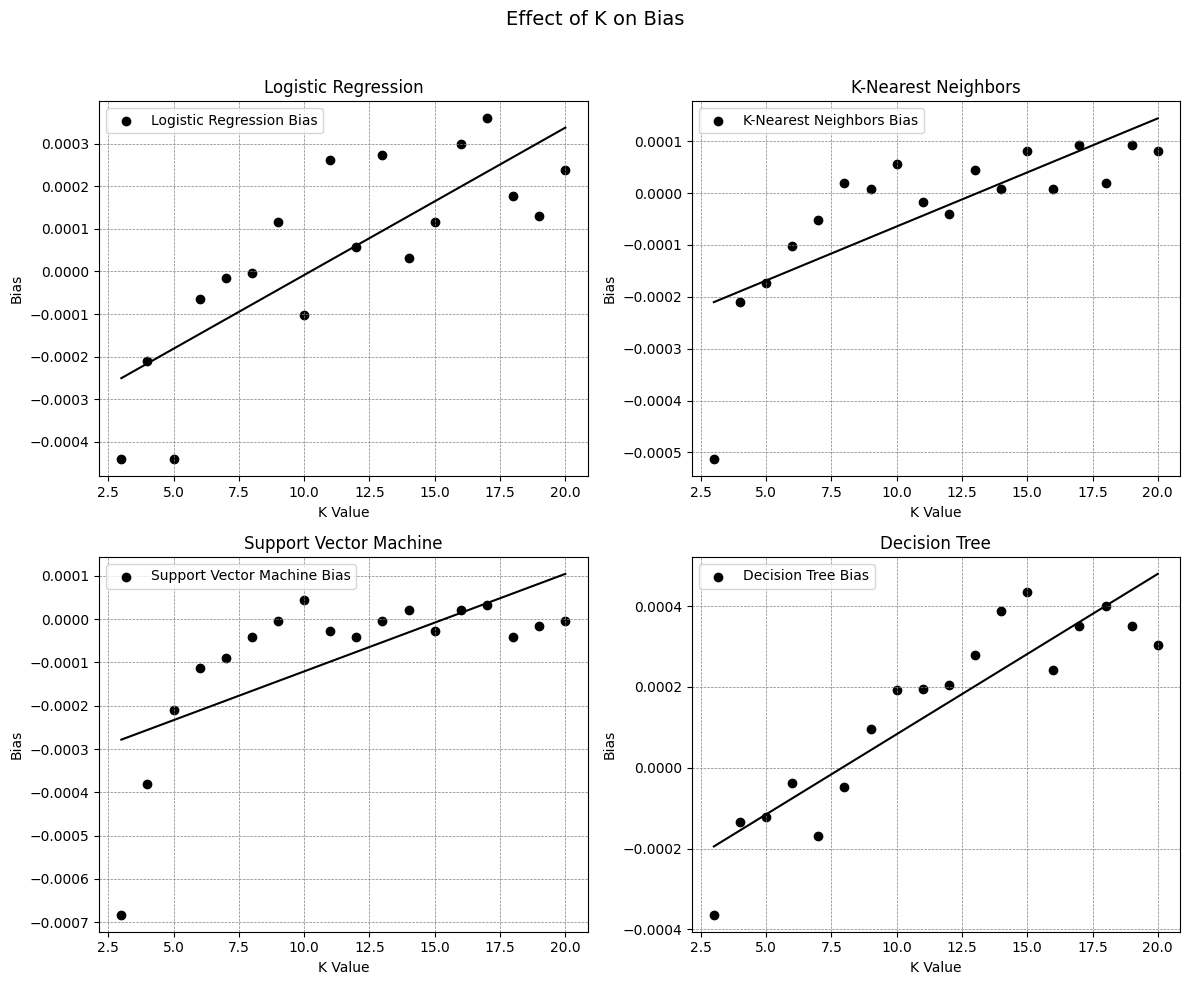

In [51]:
# Function to plot grouped Bias and Variance graphs (4 per image)
def plot_grouped_results(df, metric, ylabel, title_suffix, filename):
    models_list = df["Model"].unique()  # Get unique model names
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Create 2x2 subplot grid

    for i, model_name in enumerate(models_list[:4]):  # Limit to 4 models
        ax = axes[i // 2, i % 2]  # Position in 2x2 grid

        # Filter data for a specific model
        model_data = df[df["Model"] == model_name]
        x = model_data["K"].values
        y = model_data[metric].values

        # Scatter plot (Black markers)
        ax.scatter(x, y, color="black", label=f"{model_name} {ylabel}")

        # Fit and plot a straight trend line (Linear regression of degree 1)
        z = np.polyfit(x, y, 1)  # Linear trend line
        p = np.poly1d(z)
        ax.plot(x, p(x), color="black")  # Solid black trend line

        # Labels and title
        ax.set_xlabel("K Value")
        ax.set_ylabel(ylabel)
        ax.set_title(f"{model_name}")

        ax.legend()
        ax.grid(color='gray', linestyle='--', linewidth=0.5)

    # Adjust layout and show plot
    plt.suptitle(title_suffix, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # Save image
    plt.show()

# Generate grouped plots for Bias and Variance (Each containing 4 graphs)
plot_grouped_results(df_results, "Variance", "Variance", "Effect of K on Variance", "variance_graph.png")
plot_grouped_results(df_results, "Bias", "Bias", "Effect of K on Bias", "bias_graphs.png")
